In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
import time
import json
from datetime import datetime
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split


from HSI_class import HSI
import zeroPadding
import augmentation as aug
import createSample as CS

start_time = time.time()

# Check if GPU is available
print("GPU Available:", torch.cuda.is_available())

# If available, print the GPU name
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))

seeded_run = True
seed = 2025
sample_per_class = 5
num_per_category_augment_1 = 10
num_per_category_augment_2 = 10
epochs = 200

batch_size =40
test_size = 0.5

random_indices = 0

GPU Available: True
GPU Name: NVIDIA GeForce RTX 4080 SUPER


Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # PyTorch determinism
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    os.environ['PYTHONHASHSEED'] = str(seed)

if seeded_run:
    set_seed(seed)
    print("seed has been set")
    print(f"seet used: {seed}")

seed has been set
seet used: 2025


In [3]:
dataset_path = r"D:\FathanAbi\tugas-akhir-model-deteksi-tumpahan-minyakl\Hyperspectral oil spill detection datasets"

datasets = []

i = 0
for filename in os.listdir(dataset_path):
    if i>9:
        break
    file_path = os.path.join(dataset_path, filename)
    if os.path.isfile(file_path):  # Check if it's a file
        print(f"Processing file: {file_path}")
        hsi = HSI(file_path)
        datasets.append(hsi)
    i += 1

Processing file: D:\FathanAbi\tugas-akhir-model-deteksi-tumpahan-minyakl\Hyperspectral oil spill detection datasets\GM01.mat
Processing file: D:\FathanAbi\tugas-akhir-model-deteksi-tumpahan-minyakl\Hyperspectral oil spill detection datasets\GM02.mat
Processing file: D:\FathanAbi\tugas-akhir-model-deteksi-tumpahan-minyakl\Hyperspectral oil spill detection datasets\GM03.mat
Processing file: D:\FathanAbi\tugas-akhir-model-deteksi-tumpahan-minyakl\Hyperspectral oil spill detection datasets\GM04.mat
Processing file: D:\FathanAbi\tugas-akhir-model-deteksi-tumpahan-minyakl\Hyperspectral oil spill detection datasets\GM05.mat
Processing file: D:\FathanAbi\tugas-akhir-model-deteksi-tumpahan-minyakl\Hyperspectral oil spill detection datasets\GM06.mat
Processing file: D:\FathanAbi\tugas-akhir-model-deteksi-tumpahan-minyakl\Hyperspectral oil spill detection datasets\GM07.mat
Processing file: D:\FathanAbi\tugas-akhir-model-deteksi-tumpahan-minyakl\Hyperspectral oil spill detection datasets\GM08.mat


In [4]:
def testWithDataset(n): 
    hsi_test = datasets[n]

    test_img = hsi_test.img
    test_gt = hsi_test.gt

    patch_size = 9
    half_patch = patch_size // 2

    height = test_img.shape[0]
    width = test_img.shape[1]

    matrix=zeroPadding.zeroPadding_3D(test_img,half_patch) #add 0 in every side of the data
    print(f"img shape: {test_img.shape}")
    print(f"img shape after padding {matrix.shape}")
    print(f"number of pixel {width * height}")

    print(f"ground truth shape: {test_gt.shape}")

    indices0 = np.argwhere(test_gt == 0)
    indices1 = np.argwhere(test_gt == 1)

    print(f"indices = 0 shape: {indices0.shape}")
    print(f"indices = 1 shape: {indices1.shape}")

    num_samples = 50

    random_indices0 = indices0[np.random.choice(len(indices0), num_samples, replace=False)]
    random_indices1 = indices1[np.random.choice(len(indices1), num_samples, replace=False)]

    test_indices = np.vstack((random_indices0, random_indices1))

    print(test_indices.shape)

    return test_indices, test_gt, matrix

In [5]:
def predict_batch(model, batch_input, device):
    test_features_np = torch.flatten(batch_input, start_dim=1)  # Flatten all dims except batch
   # convert to NumPy

    predicted_classes = model.predict(test_features_np)
    probs = model.predict_proba(test_features_np)
    positive_probs = probs[:, 1]  # probability of class 1


    return predicted_classes, positive_probs


In [6]:
hsi_ = datasets[0]
patch_size = 9


indices_0 = []
indices_1 = []

print(f"random: {random_indices}")
random_indices = 1
if random_indices:
    print("generating random sample")
    selected_patch_0, selected_patch_1, indices_0, indices_1 = CS.createSample(hsi_, patch_size, sample_per_class)
else:
    print("using generated indices")
    indices_0 = [(np.int64(188), np.int64(124)), (np.int64(523), np.int64(150)), (np.int64(1003), np.int64(474)), (np.int64(616), np.int64(508)), (np.int64(905), np.int64(552))]
    indices_1 = [(np.int64(106), np.int64(606)), (np.int64(297), np.int64(468)), (np.int64(926), np.int64(35)), (np.int64(536), np.int64(519)), (np.int64(508), np.int64(442))]

    selected_patch_0, selected_patch_1 = CS.getSample(hsi_, patch_size, sample_per_class, indices_0, indices_1)


i =0
half_patch = patch_size // 2


indices = indices_0 +  indices_1

# Concatenating along axis 0
x_train = np.concatenate((selected_patch_0, selected_patch_1), )

y_train = np.array([])

gt = hsi_.gt
for indice in indices:
    # print(gt[indice[0]][indice[1]])
    y_train = np.append(y_train, gt[indice[0]][indice[1]])

count = np.count_nonzero(y_train == 0)  # Count elements equal to 0
print(f'number of element equal 0 {count}')

count = np.count_nonzero(y_train == 1)  # Count elements equal to 1
print(f'number of element equal 1 {count}')



# Print shape to verify
print(f"x_train shape: {x_train.shape}")  # Expected output: (10, 9, 9, 224)
print(f"y_train shape: {y_train.shape}") 


random: 0
generating random sample
hsi shape
(1243, 684, 224)
creating 5 Randomly chosen 0 indices:
creating 5 Randomly chosen 1 indices:
indices 0 used: [(np.int64(888), np.int64(614)), (np.int64(131), np.int64(311)), (np.int64(1028), np.int64(191)), (np.int64(765), np.int64(72)), (np.int64(282), np.int64(404))]
indices 1 used: [(np.int64(510), np.int64(201)), (np.int64(1), np.int64(28)), (np.int64(299), np.int64(654)), (np.int64(304), np.int64(270)), (np.int64(551), np.int64(377))]
number of element equal 0 5
number of element equal 1 5
x_train shape: (10, 9, 9, 224)
y_train shape: (10,)


In [7]:
i =1
half_patch = patch_size // 2
print(hsi_.img[indices_0[i][0]][indices_0[i][1]])
print(selected_patch_0[i][half_patch][half_patch])

print(hsi_.img[indices_1[i][0]][indices_1[i][1]])
print(selected_patch_1[i][half_patch][half_patch])
i =4
half_patch = patch_size // 2
print(hsi_.img[indices_0[i][0]][indices_0[i][1]])
print(selected_patch_0[i][half_patch][half_patch])

print(hsi_.img[indices_1[i][0]][indices_1[i][1]])
print(selected_patch_1[i][half_patch][half_patch])

[-225 -492  353  398  407  550  609  626  590  551  520  477  447  411
  387  356  341  312  290  261  232  210  190  159  135  126  119  107
  101   90   93   83   84   80   77   66   48   46   31    2   20   32
   42    3   26   29   24   24   23    1    9   14   31   30   28   18
   20    4  -11  -13   -8  -65 -175  -88  -10   -1   10   14   20   21
   21   21   19   19   16   15   10    7   -5  -26 -174 -222 -127 -136
  -48   -8   -2   -3    1   -7    6    3    9   11   10   14   10    0
   11    8    2   -3   -8    4  -41  -74    0    0    0    0    0    0
    0    0 -151 -343  -85  -59  -86  -68  -25   -8    2    3    5   10
   13    3    3    8    8    9    4    8    6    6    1    7   14    7
    5   11   10    9    0   -5    0    1   -3  -33  -64 -197    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
  -40  -28  -26    0   -1  -17  -48  -15   -4    4    0    6    3    3
    4    3    6    8    4    7    9    4    6    6   -1    4    0   16
    4 

In [8]:
n_category = 2
band_size = 224

data_augment1, label_augment1 = aug.Augment_data(x_train, y_train, n_category, patch_size, band_size, num_per_category_augment_1)

data_augment2, label_augment2 = aug.Augment_data2(x_train, y_train, n_category, patch_size, band_size, num_per_category_augment_2)

print(f"hasil augmentasi 1 shape: {data_augment1.shape}")
print(f"label augmentai 1 shape: {label_augment1.shape}")

print(f"hasil augmentasi 2 shape: {data_augment2.shape}")
print(f"label augmentasi 2 shape: {label_augment2.shape}")

print(label_augment1)
print(label_augment2)

data_augment = np.concatenate((data_augment1, data_augment2))
label_augment = np.concatenate((label_augment1, label_augment2))

print(f"hasil augmentasi gabungan untuk training: {data_augment.shape}")
print(f"label augmentasi gabungan: {label_augment.shape}")

# print(label_augment)

# Count occurrences of each unique element
counts = np.bincount(label_augment)

# Print results
for i, count in enumerate(counts):
    print(f"Element {i} occurs {count} times.")

hasil augmentasi 1 shape: (20, 9, 9, 224)
label augmentai 1 shape: (20,)
hasil augmentasi 2 shape: (20, 9, 9, 224)
label augmentasi 2 shape: (20,)
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
hasil augmentasi gabungan untuk training: (40, 9, 9, 224)
label augmentasi gabungan: (40,)
Element 0 occurs 20 times.
Element 1 occurs 20 times.


In [9]:
# class ConvTo1D(nn.Module):
#     def __init__(self):
#         super(ConvTo1D, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels=224, out_channels=64, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
#         self.pool = nn.AdaptiveAvgPool2d((1, 1))  # (batch_size, 128, 1, 1)
#         self.flatten = nn.Flatten()               # (batch_size, 128)

#     def forward(self, x):
#         x = F.relu(self.conv1(x))
#         x = F.relu(self.conv2(x))
#         x = self.pool(x)
#         x = self.flatten(x)
#         return x

# feature_extractor = ConvTo1D()

In [10]:
print(data_augment.shape)
print(label_augment.shape)

x_data = data_augment 
y_labels = label_augment

x_data = torch.tensor(x_data)
x_data = x_data.to(torch.float32)
x_data = x_data.permute(0, 3, 1, 2)
print(f"X_train shape: {x_data.shape}")

features_np = torch.flatten(x_data, start_dim=1)  # Flatten all dims except batch


(40, 9, 9, 224)
(40,)
X_train shape: torch.Size([40, 224, 9, 9])


In [11]:
X = features_np
y = y_labels
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=seed)

print(y_train)
print(y_val)

[0 1 1 0 0 0 0 1 1 0 0 0 1 1 1 0 1 1 1 1]
[0 0 1 0 1 1 0 0 1 0 1 1 0 1 0 0 0 1 0 1]


In [12]:
# --- Train SVM with probability enabled and deterministic behavior ---
pipeline = make_pipeline(
    StandardScaler(),
    SVC(kernel='rbf', C=100, gamma="scale", probability=True, random_state=seed)
)
pipeline.fit(X_train, y_train)

# --- Evaluate on validation set ---
predicted_classes = pipeline.predict(X_val)
probs = pipeline.predict_proba(X_val)
positive_probs = probs[:, 1]  # probability of class 1

# Combine both into a display
for i, (pred, prob) in enumerate(zip(predicted_classes, positive_probs)):
    print(f"Sample {i}: Predicted = {pred}, Prob(class 1) = {prob:.4f}")

# y_pred = svm.predict(X_val)
acc = accuracy_score(y_val, predicted_classes)
print(f"Validation Accuracy: {acc:.4f}")

# print("Classification Report:")
# print(classification_report(y_val, y_pred))

# print(y_pred)

Sample 0: Predicted = 0, Prob(class 1) = 0.1680
Sample 1: Predicted = 0, Prob(class 1) = 0.2054
Sample 2: Predicted = 1, Prob(class 1) = 0.9028
Sample 3: Predicted = 0, Prob(class 1) = 0.1600
Sample 4: Predicted = 1, Prob(class 1) = 0.9101
Sample 5: Predicted = 1, Prob(class 1) = 0.8990
Sample 6: Predicted = 0, Prob(class 1) = 0.2864
Sample 7: Predicted = 0, Prob(class 1) = 0.0664
Sample 8: Predicted = 1, Prob(class 1) = 0.7463
Sample 9: Predicted = 0, Prob(class 1) = 0.2754
Sample 10: Predicted = 1, Prob(class 1) = 0.7718
Sample 11: Predicted = 1, Prob(class 1) = 0.8629
Sample 12: Predicted = 0, Prob(class 1) = 0.1773
Sample 13: Predicted = 1, Prob(class 1) = 0.9007
Sample 14: Predicted = 0, Prob(class 1) = 0.2701
Sample 15: Predicted = 0, Prob(class 1) = 0.1206
Sample 16: Predicted = 0, Prob(class 1) = 0.1170
Sample 17: Predicted = 1, Prob(class 1) = 0.8494
Sample 18: Predicted = 0, Prob(class 1) = 0.0881
Sample 19: Predicted = 1, Prob(class 1) = 0.9100
Validation Accuracy: 1.0000


d:\FathanAbi\fathanvenv\Lib\site-packages\sklearnex\svm\_common.py:249: RuntimeWarning: random_state does not influence oneDAL SVM results
  warnings.warn(
d:\FathanAbi\fathanvenv\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


In [13]:
def testWithWholeDataset(n): 
    hsi_test = datasets[n]

    test_img = hsi_test.img
    gt= hsi_test.gt

    patch_size = 9
    half_patch = patch_size // 2

    height = test_img.shape[0]
    width = test_img.shape[1]

    matrix=zeroPadding.zeroPadding_3D(test_img,half_patch) #add 0 in every side of the data
    print(f"img shape: {test_img.shape}")
    print(f"img shape after padding {matrix.shape}")
    print(f"number of pixel {width * height}")

    print(f"ground truth shape: {gt.shape}")

    indices0 = np.argwhere(gt == 0)
    indices1 = np.argwhere(gt == 1)

    print(f"indices = 0 shape: {indices0.shape}")
    print(f"indices = 1 shape: {indices1.shape}")

    return matrix, gt, indices0.shape, indices1.shape

In [14]:
def predict_batch_whole(pipeline, batch_input, device):
  test_features_np = torch.flatten(batch_input, start_dim=1)  # Flatten all dims except batch


  # --- Evaluate on validation set ---
  predicted_classes = pipeline.predict(test_features_np)
  probs = pipeline.predict_proba(test_features_np)
  positive_probs = probs[:, 1]  # probability of class 1

  return predicted_classes, positive_probs
   

In [15]:
class PatchDataset(Dataset):
    def __init__(self, matrix, gt, half_patch, expected_shape):
        self.matrix = matrix
        self.gt = gt
        self.half_patch = half_patch
        self.expected_shape = expected_shape
        self.size_x, self.size_y = matrix.shape[0], matrix.shape[1]
        self.valid_coords = [
            (x, y)
            for x in range(half_patch, self.size_x - half_patch)
            for y in range(half_patch, self.size_y - half_patch)
        ]

    def __len__(self):
        return len(self.valid_coords)

    def __getitem__(self, idx):
        x, y = self.valid_coords[idx]
        true_label = self.gt[x - self.half_patch, y - self.half_patch]

        selected_rows = self.matrix[x- self.half_patch:x + 2 * self.half_patch + 1 - self.half_patch, :]
        testing_patch = selected_rows[:, y - self.half_patch:y + 2 * self.half_patch + 1 - self.half_patch]

        # Verify patch size
        if testing_patch.shape != self.expected_shape:
            raise ValueError(f"Patch at ({x},{y}) has wrong shape {testing_patch.shape}")

        patch_tensor = torch.tensor(testing_patch, dtype=torch.float32)
        patch_tensor = patch_tensor.permute(2, 0, 1)  # (C, H, W)

        return patch_tensor, true_label, x, y  # Also return (x, y) for positioning later

In [16]:
def getScore(prediction, y_probs, groundtruth):
    groundtruths = groundtruth
    groundtruth_in = []

    for x in groundtruths:
        groundtruth_in.append(x)

    predictions = prediction
    prediction_in = []

    for x in predictions:
        for y in x:
            prediction_in.append(y)


    y_prob_in = []

    for x in y_probs:
        for y in x:
            y_prob_in.append(y)

    # print(len(groundtruth_in))
    # print(len(prediction_in))
    # print(len(y_prob_in))

    y_test = groundtruth_in
    y_pred = prediction_in
    correct = 0
    total = 0
    for x, y in zip(y_test, y_pred):
        total += 1
        if x == y:
            correct += 1
    
    print(f'{correct}/{total}')

    y_test_np = np.array([label.item() for label in y_test])
    # Ensure labels are binary (0 and 1)
    # print("Unique values in y_test:", pd.Series(y_test_np).unique())

    # # Check if y_pred is probability (float) or hard prediction (int)
    # print("Sample y_pred values:", y_pred[:5])

    test_df = pd.DataFrame(
        {'True': y_test_np, 'Model': y_prob_in})

    plt.figure(figsize=(7, 5))


    fpr, tpr, _ = roc_curve(test_df['True'], test_df['Model'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Model (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Two Models')
    plt.legend()
    plt.show()

    

    y_true = np.array([int(label) for label in y_test_np])  # true labels
    y_pred = prediction_in                         # predicted class labels (e.g., from predict_batch)

    # Precision, Recall, F1
    precision = precision_score(y_true, y_pred, average='macro')  # Use 'binary' if binary task
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    # Overall Accuracy (OA)
    oa = accuracy_score(y_true, y_pred)

    # Average Accuracy (AA) — mean of per-class accuracies
    cm = confusion_matrix(y_true, y_pred)
    per_class_acc = cm.diagonal() / cm.sum(axis=1)
    aa = per_class_acc.mean()

    # Print all metrics
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"OA:        {oa:.4f}")
    print(f"AA:        {aa:.4f}")

    performance = {
        'AUC': float(roc_auc),
        'precision': float(precision),
        'recall': float(recall),
        'F1 Score': float(f1),
        'OA': float(oa),
        'AA': float(aa),
    }

    return performance

dataset: 1
img shape: (1243, 684, 224)
img shape after padding (1251, 692, 224)
number of pixel 850212
ground truth shape: (1243, 684)
indices = 0 shape: (820876, 2)
indices = 1 shape: (29336, 2)
820876
29336
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 13285


Predicting: 100%|██████████| 13285/13285 [03:05<00:00, 71.56it/s]


691563/850212


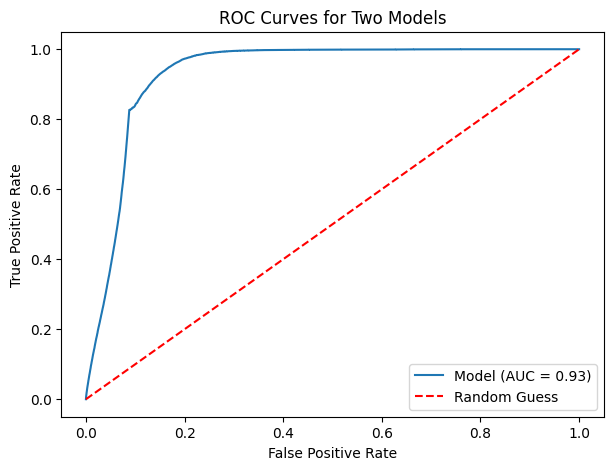

Precision: 0.5756
Recall:    0.8878
F1 Score:  0.5784
OA:        0.8134
AA:        0.8878
correct0 = 663175
correct1 = 28388
Score: 691563/850212
dataset: 2
img shape: (1786, 699, 224)
img shape after padding (1794, 707, 224)
number of pixel 1248414
ground truth shape: (1786, 699)
indices = 0 shape: (1236269, 2)
indices = 1 shape: (12145, 2)
1236269
12145
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 19507


Predicting: 100%|██████████| 19507/19507 [04:51<00:00, 66.90it/s]


46374/1248414


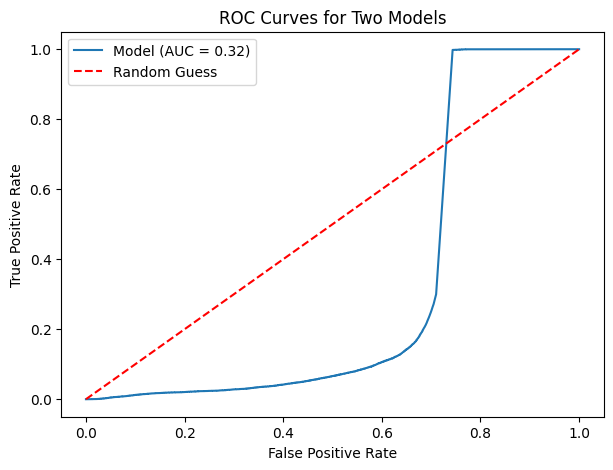

Precision: 0.5050
Recall:    0.5138
F1 Score:  0.0368
OA:        0.0371
AA:        0.5138
correct0 = 34229
correct1 = 12145
Score: 46374/1248414
dataset: 3
img shape: (1386, 690, 224)
img shape after padding (1394, 698, 224)
number of pixel 956340
ground truth shape: (1386, 690)
indices = 0 shape: (916980, 2)
indices = 1 shape: (39360, 2)
916980
39360
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 14943


Predicting: 100%|██████████| 14943/14943 [03:40<00:00, 67.88it/s]


553022/956340


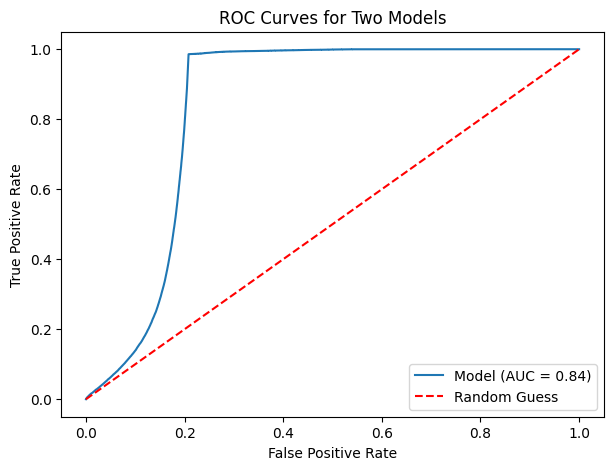

Precision: 0.5443
Recall:    0.7790
F1 Score:  0.4406
OA:        0.5783
AA:        0.7790
correct0 = 513750
correct1 = 39272
Score: 553022/956340
dataset: 4
img shape: (1466, 676, 224)
img shape after padding (1474, 684, 224)
number of pixel 991016
ground truth shape: (1466, 676)
indices = 0 shape: (959167, 2)
indices = 1 shape: (31849, 2)
959167
31849
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 15485


Predicting: 100%|██████████| 15485/15485 [03:49<00:00, 67.38it/s]


645079/991016


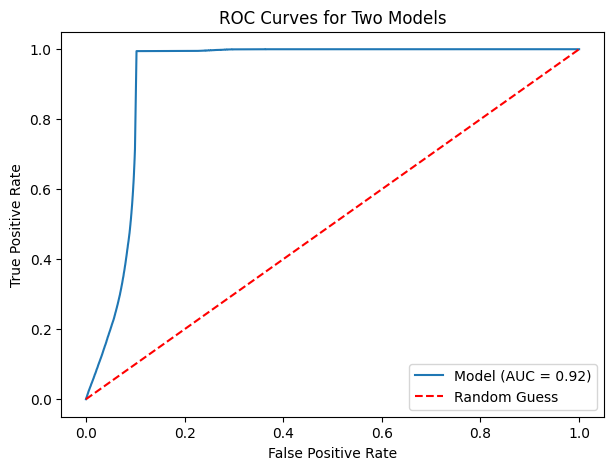

Precision: 0.5421
Recall:    0.8196
F1 Score:  0.4677
OA:        0.6509
AA:        0.8196
correct0 = 613233
correct1 = 31846
Score: 645079/991016
dataset: 5
img shape: (2085, 682, 224)
img shape after padding (2093, 690, 224)
number of pixel 1421970
ground truth shape: (2085, 682)
indices = 0 shape: (1363408, 2)
indices = 1 shape: (58562, 2)
1363408
58562
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 22219


Predicting: 100%|██████████| 22219/22219 [05:35<00:00, 66.26it/s]


492190/1421970


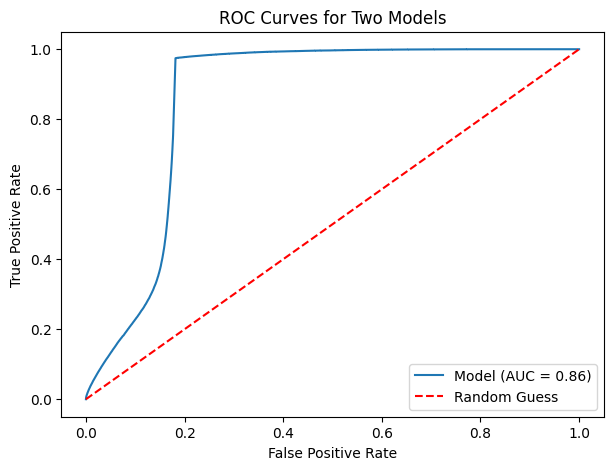

Precision: 0.5296
Recall:    0.6588
F1 Score:  0.2972
OA:        0.3461
AA:        0.6588
correct0 = 433660
correct1 = 58530
Score: 492190/1421970
dataset: 6
img shape: (2088, 691, 224)
img shape after padding (2096, 699, 224)
number of pixel 1442808
ground truth shape: (2088, 691)
indices = 0 shape: (1389552, 2)
indices = 1 shape: (53256, 2)
1389552
53256
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 22544


Predicting: 100%|██████████| 22544/22544 [05:24<00:00, 69.41it/s]


642427/1442808


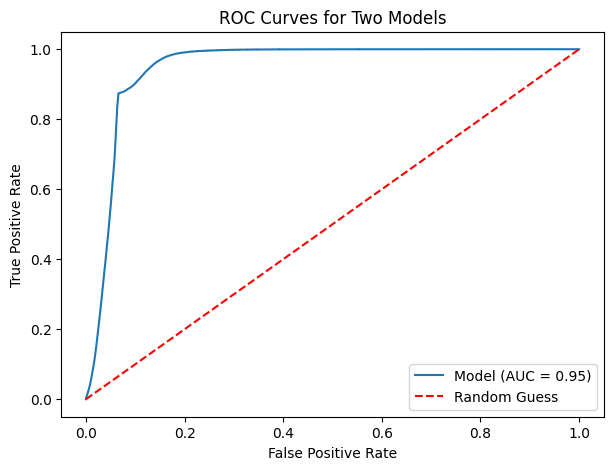

Precision: 0.5312
Recall:    0.7119
F1 Score:  0.3565
OA:        0.4453
AA:        0.7119
correct0 = 589177
correct1 = 53250
Score: 642427/1442808
dataset: 7
img shape: (1965, 492, 224)
img shape after padding (1973, 500, 224)
number of pixel 966780
ground truth shape: (1965, 492)
indices = 0 shape: (873365, 2)
indices = 1 shape: (93415, 2)
873365
93415
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 15106


Predicting: 100%|██████████| 15106/15106 [03:37<00:00, 69.43it/s]


93415/966780


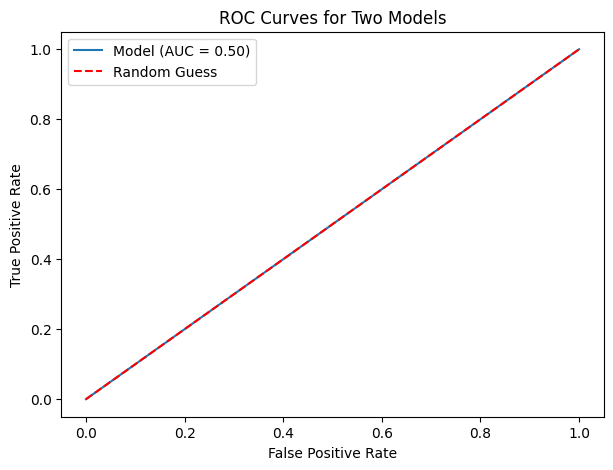

d:\FathanAbi\fathanvenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: 0.0483
Recall:    0.5000
F1 Score:  0.0881
OA:        0.0966
AA:        0.5000
correct0 = 0
correct1 = 93415
Score: 93415/966780
dataset: 8
img shape: (1532, 567, 224)
img shape after padding (1540, 575, 224)
number of pixel 868644
ground truth shape: (1532, 567)
indices = 0 shape: (824964, 2)
indices = 1 shape: (43680, 2)
824964
43680
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 13573


Predicting: 100%|██████████| 13573/13573 [03:17<00:00, 68.58it/s]


43680/868644


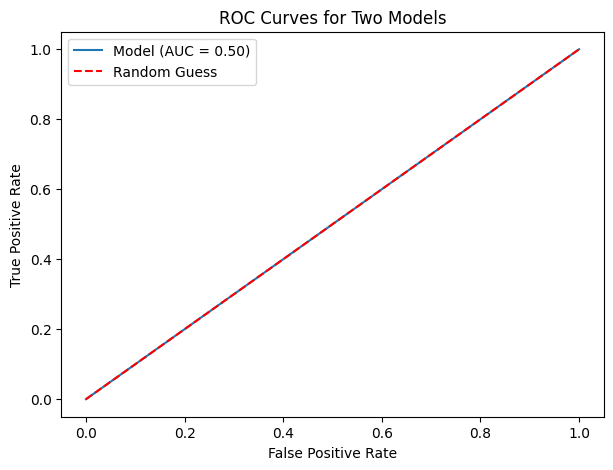

d:\FathanAbi\fathanvenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: 0.0251
Recall:    0.5000
F1 Score:  0.0479
OA:        0.0503
AA:        0.5000
correct0 = 0
correct1 = 43680
Score: 43680/868644
dataset: 9
img shape: (1569, 517, 224)
img shape after padding (1577, 525, 224)
number of pixel 811173
ground truth shape: (1569, 517)
indices = 0 shape: (742935, 2)
indices = 1 shape: (68238, 2)
742935
68238
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 12675


Predicting: 100%|██████████| 12675/12675 [03:03<00:00, 69.19it/s]


68238/811173


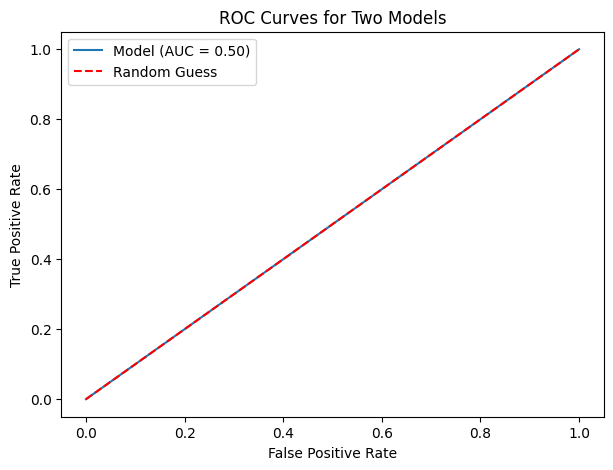

d:\FathanAbi\fathanvenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: 0.0421
Recall:    0.5000
F1 Score:  0.0776
OA:        0.0841
AA:        0.5000
correct0 = 0
correct1 = 68238
Score: 68238/811173
dataset: 10
img shape: (1084, 680, 224)
img shape after padding (1092, 688, 224)
number of pixel 737120
ground truth shape: (1084, 680)
indices = 0 shape: (691437, 2)
indices = 1 shape: (45683, 2)
691437
45683
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 11518


Predicting: 100%|██████████| 11518/11518 [02:43<00:00, 70.35it/s]


45683/737120


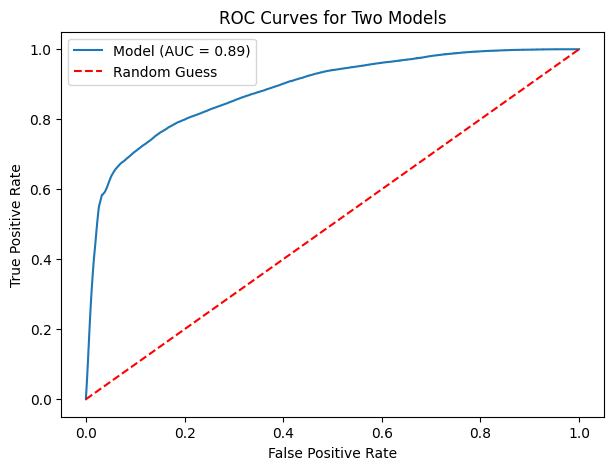

d:\FathanAbi\fathanvenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: 0.0310
Recall:    0.5000
F1 Score:  0.0584
OA:        0.0620
AA:        0.5000
correct0 = 0
correct1 = 45683
Score: 45683/737120


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

scores = []
groundtruth = []
prediction = []
y_probs = []


timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
os.makedirs(f"predictions/{timestamp}", exist_ok=True)
for dataset in range(len(datasets)):
    # if dataset > 2:
    #     break
    print(f"dataset: {dataset + 1}")
    hsi_prediction = []
    hsi_yprobs = []
    hsi_groundtruth = []

    score = []
    patch_size = 9
    half_patch = patch_size // 2

    data_sampler = None
    batch_size = 64

    correct0 = 0
    correct1 = 0
    matrix = []
    gt = []
    expected_patch_shape = []
    dataset_patches = []
    data_loader = []
    patch_tensor = []
    true_label = [] 
    x = []
    y = []
    pred_matrix = []

    matrix, gt, indices_0_shape, indices_1_shape = testWithWholeDataset(dataset)
    print(indices_0_shape[0])
    print(indices_1_shape[0])

    expected_patch_shape = (2 * half_patch + 1, 2 * half_patch + 1, matrix.shape[2])
    dataset_patches = PatchDataset(matrix, gt, half_patch, expected_patch_shape)

    if seeded_run:
        g = torch.Generator()
        g.manual_seed(seed)

        data_loader = DataLoader(
            dataset_patches,
            batch_size=batch_size,
            shuffle=False,  # set to True if needed
            num_workers=0,
            pin_memory=True,
            drop_last=False,
            generator=g
        )
        print("generate data loader using seed")
    else:
        data_loader = DataLoader(dataset_patches, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True, drop_last=False)




    patch_tensor, true_label, x, y = next(iter(data_loader))

    print(patch_tensor.size())
    print(true_label.size())
    print(f"data loader size: {len(data_loader)}")

    pred_matrix = np.full(gt.shape, -1, dtype=np.int32)
    correct = 0

    for input_batch, label_batch, x_batch, y_batch in tqdm(data_loader, desc="Predicting"):


        preds, confs = predict_batch_whole(pipeline, input_batch, device)

        hsi_prediction.append(preds)
        prediction.append(preds)
        hsi_yprobs.append(confs)
        y_probs.append(confs)
        
        label_batch = label_batch.numpy()
        x_batch = x_batch.numpy()
        y_batch = y_batch.numpy()

        for pred, label, x, y in zip(preds, label_batch, x_batch, y_batch):
            hsi_groundtruth.append(label)
            groundtruth.append(label)
            pred_matrix[x - half_patch, y - half_patch] = pred
            if pred == label:
                if label == 0:
                    correct0 += 1
                elif label == 1:
                    correct1 += 1

    performance_metrics = getScore(hsi_prediction, hsi_yprobs, hsi_groundtruth)      
          
    correct = correct0+correct1
    print(f"correct0 = {correct0}")
    print(f"correct1 = {correct1}")
    total = gt.shape[0] * gt.shape[1]
    print(f"Score: {correct}/{total}")

    score = {
        'dataset': dataset,
        'class0_size': indices_0_shape[0],
        'class1_size': indices_1_shape[0],
        'correct_0': correct0,
        'correct_1': correct1,
        'correct_total': correct,
        'total': total,
        'AUC': float(performance_metrics['AUC']),
        'precision': float(performance_metrics['precision']),
        'recall': float(performance_metrics['recall']),
        'F1 Score': float(performance_metrics['F1 Score']),
        'OA': float(performance_metrics['OA']),
        'AA': float(performance_metrics['AA']),
    }
    # print(score)
    scores.append(score)
    # Save prediction matrix
    # timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    np.save(f"predictions/{timestamp}/results {dataset} SVM.npy", pred_matrix)

In [18]:
all_correct = 0
all_total = 0
all_correct0 = 0
all_correct1 = 0
class0_total = 0
class1_total = 0


for score in scores:
    dataset = score['dataset']
    correct0 = score['correct_0']
    correct1 = score['correct_1']
    class0_size = score['class0_size']
    class1_size = score['class1_size']
    correct = score['correct_total']
    total = score['total']
    auc_score = score['AUC']
    precission = score['precision']
    recall = score['recall']
    f1 = score['F1 Score']
    oa = score['OA']
    aa = score['AA']
    
    print(f"dataset: {dataset}\t", f'{correct0}/{class0_size}\t', f'{correct1}/{class1_size}\t', f'{correct}/{total}\t', f"{oa}", f"{aa}")

    all_correct += correct
    all_total += total
    all_correct0 += correct0
    all_correct1 += correct1
    class0_total += class0_size
    class1_total += class1_size


for score in scores:
    dataset = score['dataset']
    correct0 = score['correct_0']
    correct1 = score['correct_1']
    class0_size = score['class0_size']
    class1_size = score['class1_size']
    correct = score['correct_total']
    total = score['total']
    auc_score = score['AUC']
    precission = score['precision']
    recall = score['recall']
    f1 = score['F1 Score']
    oa = score['OA']
    aa = score['AA']
    print(f"dataset: {dataset}\t", f"AUC: {auc_score}", f"precission: {precission}", f"recall: {recall}", f"F1 SCore{f1}")

print(f"total: \t\t {all_correct0}/{class0_total/2} \t {all_correct1}/{class1_total/2} \t {all_correct}/{all_total}")

print(f"acc: {all_correct/all_total}")




dataset: 0	 663175/820876	 28388/29336	 691563/850212	 0.8134006577183103 0.8877858481121659
dataset: 1	 34229/1236269	 12145/12145	 46374/1248414	 0.03714633126510917 0.5138436699456186
dataset: 2	 513750/916980	 39272/39360	 553022/956340	 0.5782692347909739 0.7790136325020255
dataset: 3	 613233/959167	 31846/31849	 645079/991016	 0.650926927516811 0.8196224702074857
dataset: 4	 433660/1363408	 58530/58562	 492190/1421970	 0.3461324781816775 0.6587620850655906
dataset: 5	 589177/1389552	 53250/53256	 642427/1442808	 0.4452616009891822 0.7119461698447342
dataset: 6	 0/873365	 93415/93415	 93415/966780	 0.09662487846252509 0.5
dataset: 7	 0/824964	 43680/43680	 43680/868644	 0.0502852722173871 0.5
dataset: 8	 0/742935	 68238/68238	 68238/811173	 0.08412262242456295 0.5
dataset: 9	 0/691437	 45683/45683	 45683/737120	 0.06197498372042544 0.5
dataset: 0	 AUC: 0.9316146949866682 precission: 0.5755616074104581 recall: 0.8877858481121659 F1 SCore0.5783595127479915
dataset: 1	 AUC: 0.3178412

In [19]:

all_total_score = {
    'dataset': 'Total Dataset',
    'correct_0': all_correct0,
    'correct_1': all_correct1,
    'class0_total': class0_total,
    'class1_total': class1_total,
    'correct_total': all_correct,
    'total': all_total
}

scores.append(all_total_score)

In [20]:
groundtruths = groundtruth
groundtruth_in = []

for x in groundtruths:
    groundtruth_in.append(x)

predictions = prediction
prediction_in = []

for x in predictions:
    for y in x:
        prediction_in.append(y)


y_prob_in = []

for x in y_probs:
    for y in x:
        y_prob_in.append(y)

print(len(groundtruth_in))
print(len(prediction_in))
print(len(y_prob_in))

10294477
10294477
10294477


In [21]:
y_test = groundtruth_in
y_pred = prediction_in
correct = 0
total = 0

for x, y in zip(y_test, y_pred):
    total += 1
    if x == y:
        correct += 1

print(f'{correct}/{total}')

3321671/10294477


In [22]:
y_test_np = np.array([label.item() for label in y_test])
# Ensure labels are binary (0 and 1)
print("Unique values in y_test:", pd.Series(y_test_np).unique())

# Check if y_pred is probability (float) or hard prediction (int)
print("Sample y_pred values:", y_pred[:5])

Unique values in y_test: [0 1]
Sample y_pred values: [np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]


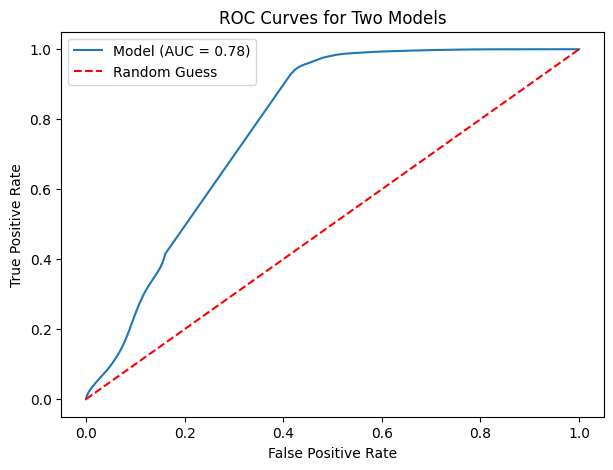

In [23]:


test_df = pd.DataFrame(
    {'True': y_test_np, 'Model': y_prob_in})

plt.figure(figsize=(7, 5))


fpr, tpr, _ = roc_curve(test_df['True'], test_df['Model'])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'Model (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Two Models')
plt.legend()
plt.show()

In [24]:


y_true = np.array([int(label) for label in y_test_np])  # true labels
y_pred = prediction_in                         # predicted class labels (e.g., from predict_batch)

# Precision, Recall, F1
precision = precision_score(y_true, y_pred, average='macro')  # Use 'binary' if binary task
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Overall Accuracy (OA)
oa = accuracy_score(y_true, y_pred)

# Average Accuracy (AA) — mean of per-class accuracies
cm = confusion_matrix(y_true, y_pred)
per_class_acc = cm.diagonal() / cm.sum(axis=1)
aa = per_class_acc.mean()

# Print all metrics
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"OA:        {oa:.4f}")
print(f"AA:        {aa:.4f}")

Precision: 0.5317
Recall:    0.6439
F1 Score:  0.2847
OA:        0.3227
AA:        0.6439


In [25]:
performance = {
    'AUC': float(roc_auc),
    'precision': float(precision),
    'recall': float(recall),
    'F1 Score': float(f1),
    'OA': float(oa),
    'AA': float(aa),
}
result_json = {
    'prediction' : scores,
    'performance' : performance,
}

In [26]:
# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
print(result_json)

with open(f"performance/SVM {timestamp}_results.json", "w") as f:
    json.dump(result_json, f, indent=2)

print("JSON saved to results.json")

{'prediction': [{'dataset': 0, 'class0_size': 820876, 'class1_size': 29336, 'correct_0': 663175, 'correct_1': 28388, 'correct_total': 691563, 'total': 850212, 'AUC': 0.9316146949866682, 'precision': 0.5755616074104581, 'recall': 0.8877858481121659, 'F1 Score': 0.5783595127479915, 'OA': 0.8134006577183103, 'AA': 0.8877858481121659}, {'dataset': 1, 'class0_size': 1236269, 'class1_size': 12145, 'correct_0': 34229, 'correct_1': 12145, 'correct_total': 46374, 'total': 1248414, 'AUC': 0.317841279086711, 'precision': 0.5050012971664121, 'recall': 0.5138436699456186, 'F1 Score': 0.03684493738604085, 'OA': 0.03714633126510917, 'AA': 0.5138436699456186}, {'dataset': 2, 'class0_size': 916980, 'class1_size': 39360, 'correct_0': 513750, 'correct_1': 39272, 'correct_total': 553022, 'total': 956340, 'AUC': 0.8380080427220266, 'precision': 0.5442893105769182, 'recall': 0.7790136325020255, 'F1 Score': 0.4405608543015245, 'OA': 0.5782692347909739, 'AA': 0.7790136325020255}, {'dataset': 3, 'class0_size':

In [27]:
end_time = time.time()
print(f"Run time: {end_time - start_time:.4f} seconds")

print(timestamp)
print(f"seet used: {seed}")

Run time: 2400.0352 seconds
20250617_164625
seet used: 2025
